# Taller Entrenamiento de LLMs

Jornadas Uruguayas de Ciencias de la Computación - 2025

En este taller vamos a ver cómo se entrena un Gran Modelo de Lenguaje (Large Language Model - LLM). Antes de hacerlo, vamos a ver alguos conceptos básicos de redes neuronales y de PyTorch (una biblioteca de Python para definir y entrenar redes). El objetivo es hacer un entrenamiento completo de una red neuronal feedforward para resolver un problema de clasificación, y luego de un LLM para una tarea... que veremos más adelante. Bienvenid@s.  

---
# Configuración inicial

Comenzamos instalando e importando las bibliotecas que utilizaremos a lo largo del notebook.


---

In [ ]:
#PyTorch
!pip install torch
!pip install torcheval
!pip install datasets

#Scikit-learn: la biblioteca más popular para aprendizaje automático del entorno Python
!pip install scikit-learn

# Visualizaciones
!pip install seaborn
!pip install matplotlib

!pip install silabeador

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torcheval.metrics as tm

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from datasets import load_dataset


random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


El objetivo de `torch.device` es muy importante: intentamos utilizar una GPU si es posible, porque de esta forma los cálculos van a ser (mucho) más rápidos.


---
# Introducción a PyTorch

En esta sección aprenderemos cómo construir y entrenar una red neuronal feed-forward utilizando Pytorch. Previamente, veremos la estructura más importante para las redes neuronales: los tensores. Los tensores son, esencialmente, arrays n-dimensionales. Cuando tienen dimensión 0, diremos que son _escalares_, cuando tienen dimensión 1 son nuestros viejos conocidos _vectores_ y cuando tienen dimensión 2 son _matrices_. Más allá de eso... los llamamos tensores n-dimensionales.


---

## Crear tensores con PyTorch

In [ ]:
z = torch.zeros(5, 3)
print(z)
print(z.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
torch.float32


In [ ]:
i = torch.ones((5, 3), dtype=torch.int16)
print(i)

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)


In [ ]:
data = [[1,2],[3,4]]
x_data = torch.tensor(data)
print(x_data)

# Convertimos una matriz de Python en un array n-dimensional de NumPy,
# y a partir de él construimos un tensor de 2 dimensiones (matriz)
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])


In [ ]:
x_ones = torch.ones_like(x_data)
print(x_ones)

x_rand = torch.rand_like(x_data, dtype=torch.float)
print(x_rand)

tensor([[1, 1],
        [1, 1]])
tensor([[0.8823, 0.9150],
        [0.3829, 0.9593]])


### Atributos de un tensor

In [ ]:
print(x_rand.shape)
print(x_rand.dtype)
print(x_rand.device)

# Pasamos el tensor a la GPU, si es posible
if torch.cuda.is_available():
    x_rand = x_rand.to("cuda")
print(x_rand.device)

torch.Size([2, 2])
torch.float32
cpu
cuda:0


### Operaciones con tensores

PyTorch permite todas las operaciones imaginables sobre tensores. Aquí mostraremos algunos ejemplos solamente. Todos los ejemplos que mostramos son sobre todo el tensor, pero también es posible trabajar sobre una dimensión en particular (por ejemplo, sumar todas las filas de una matriz, u obtener el promedio de todas las columnas), entre otras muchas opciones.

In [ ]:
ones = torch.ones(2, 3)
print(ones)

twos = torch.ones(2, 3) * 2
print(twos)

threes = ones + twos
print(threes)
print(threes.shape)

# r1 = torch.rand(2, 3)
# r2 = torch.rand(3, 2)

# r12 = r1 + r2

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 2., 2.],
        [2., 2., 2.]])
tensor([[3., 3., 3.],
        [3., 3., 3.]])
torch.Size([2, 3])


In [ ]:
# Valores entre -1 y 1
print("Vector random:")
r = (torch.rand(2, 2) - 0.5) * 2
print(r)

# Valor absoluto
print("\nValor absoluto:")
print(torch.abs(r))

# Arcoseno
print("\nArcoseno:")
print(torch.asin(r))

# Determinante
print("\nDeterminante:")
print(torch.det(r))

# Descomposición por valores singulares
print("\nDescomposición por valores singulares:")
print(torch.svd(r))

# Promedio y desviación estándar
print("\nPromedio y desviación estándar:")
print(torch.std_mean(r))

# Encontrar el valor máximo
print("\nValor máximo:")
print(torch.max(r))

Vector random:
tensor([[-0.2191,  0.2018],
        [-0.4869,  0.5873]])

Valor absoluto:
tensor([[0.2191, 0.2018],
        [0.4869, 0.5873]])

Arcoseno:
tensor([[-0.2209,  0.2032],
        [-0.5085,  0.6277]])

Determinante:
tensor(-0.0304)

Descomposición por valores singulares:
torch.return_types.svd(
U=tensor([[-0.3616, -0.9323],
        [-0.9323,  0.3616]]),
S=tensor([0.8181, 0.0372]),
V=tensor([[ 0.6517,  0.7585],
        [-0.7585,  0.6517]]))

Promedio y desviación estándar:
(tensor(0.4722), tensor(0.0208))

Valor máximo:
tensor(0.5873)


## Ejemplo de FFNN

Lo primero que vamos a hacer es entrenar una red neuronal feed forward para que clasifique reseñas de películas en Positivas y Negativas. Para esto, tendremos que:

1. Ver cómo representar los textos de entrada (las redes neuronales solamente admiten como entradas vectores de números reales).
1. Construir una red adecuada, especificando sus capas y la forma de entrenarla
1. Entrenar la red utilizando datos de entrenamiento
1. Evaluar los resultados.

Iremos paso a paso...

### Cargar y preprocesar datos

Primero descargamos el dataset de reseñas de IMDB que vamos a utilizar. Veremos que este conjunto tiene un conjunto de _instancias_, cada una compuesta por un texto (la reseña), y una categoría asociada, que vale 1 si la reseña es positiva, y 0 si es negativa.

Podemos ver también que el conjunto está dividido en dos partes: el conjunto de train (que utilizaremos para entrenar) y el conjunto de test (que utilizaremos para evaluar). En nuestro caso, ya viene separado, pero muchas veces este trabajo es parte del método de entrenamiento, y tiene (muchos) aspectos a tener en cuenta.

In [ ]:
train_iter = load_dataset("stanfordnlp/imdb", split="train")
test_iter = load_dataset("stanfordnlp/imdb", split="test")

print(f"Tamaño de train: {len(train_iter)}")
print(f"Tamaño de test: {len(test_iter)}")

# Ejemplo negativo
negative_example = next(data["text"] for data in train_iter if data["label"] == 0)
print(f"\nEjemplo negativo:\n{negative_example}")

# Ejemplo positivo
positive_example = next(data["text"] for data in train_iter if data["label"] == 1)
print(f"\nEjemplo positivo:\n{positive_example}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Tamaño de train: 25000
Tamaño de test: 25000

Ejemplo negativo:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic

Ahora, utilizaremos scikit-learn para:

1. Convertir las reviews a vectores utilizando la representación de Bag of Words
2. Usar SVD para reducir la dimensionalidad de los vectores a tamaño 500

(Esto va a demorar un ratito)

In [ ]:
X = train_iter["text"]

# CountVectorizer permite convertir un texto en un vector, contando la cantidad de apariciones de cada palabra
vectorizer_bow = CountVectorizer(analyzer='word')
vectorizer_bow = vectorizer_bow.fit(X)

# Convertimos nuestros textos de entrenamiento a BOW
# Este vector tendrá tantas columnas como palabras tenga nuestro vocabulario
X_bow = vectorizer_bow.transform(X)

# Utilizamos SVD para obtener vectores en las 500 componentes principales
vectorizer_svd = TruncatedSVD(n_components=500, n_iter=10, random_state=432)
vectorizer_svd = vectorizer_svd.fit(X_bow)

# Esta función realiza el proceso para un  nuevo dataset
def transform_data(iter):
    X = iter["text"]
    y = iter["label"]

    # Toma el texto y lo vectoriza
    X_bow = vectorizer_bow.transform(X)
    X_svd = vectorizer_svd.transform(X_bow)

    return X_svd, y

In [ ]:
print(X_bow.shape)
print(vectorizer_svd.transform(X_bow).shape)

(25000, 74849)
(25000, 500)


Crearemos un custom Dataset de pytorch para almacenar nuestros conjuntos de train y test. Los Datasets de PyTorch nos permiten gestionar de una forma estándar un conjunto de datos. Vemos que tiene métodos para inicializarlo, para obtener el largo y para ir obteniendo cada uno de sus elmenetos.

In [ ]:
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, iter):
        X, y = transform_data(iter)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = IMDBDataset(train_iter)
test_dataset = IMDBDataset(test_iter)

Luego, inicializamos DataLoaders para la manipulación de los datasets. Los DataLoaders nos permiten hacer algunas operaciones adicionales al momento de leer los datos para el entrenamiento. Por ejemplo, ver de a cuántos ejemplos por vez (llamados _batchs_) vamos procesando (`batch_size`), o indicar que se mezcle el dataset antes de utilizarlo.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print(f"Tamaño de train_dataloader: {len(train_dataloader)}")
print(f"Tamaño de primer batch de train_dataloader: {len(next(iter(train_dataloader))[0])}")

Tamaño de train_dataloader: 391
Tamaño de primer batch de train_dataloader: 64


### Crear modelo de red neuronal

Definimos ahora la arquitectura de la red feedforward. Estas redes tienen una o más capas ocultas, cada una de ellas conectada con la anterior (siendo la primera capa el vector con la entrada).  En cada capa hay varias neuronas, que realizan una combinación lineal de sus entradas y le aplican una _función de activación_ no lineal. En la última capa tendremos una o más neuronas de _salida_, que darán el resultado de la red.  

En nuestro ejemplo, construiremos una capa oculta de tamaño 200 con función de activación ReLU para la capa oculta, y una función de activación Sigmoide para la capa de salida

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(500, 200)
    self.fc2 = nn.Linear(200, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    return x

my_net = Net()
print(my_net)

y = my_net(torch.randn(1, 500))
print(f"\n{y}")

Net(
  (fc1): Linear(in_features=500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
)

tensor([[0.5544]], grad_fn=<SigmoidBackward0>)


Podemos acceder a las matrices de pesos del modelo:

In [ ]:
my_net.fc1.weight.shape

torch.Size([200, 500])

### Entrenamiento

Hasta ahora, nuestra red (inicializada con pesos aleatorios) devuelve valores que no tienen ninguna relación con las categorías que buscamos. Lo que haremos durante el _entrenamiento_ será utilizar los ejemplos donde ya conocemos la categoría correcta para ajustar los pesos de la red. Para esto, vamos a necesitar definir dos artefactos importantes: la _función de pérdida o error_ (que nos dice cuánto difiere la salida de la red con los pesos actuales de la categoría correcta), y el algoritmo de optimización que utilizaremos para minimizar esa función. En nuestro ejemplo, utilizaremos _entropía cruzada_ y _descenso por gradiente_ ,respectivamente.

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=.9)

Definido esto, ya podemos entrenar. Para esto, construimos un loop que lo que hace es recibir cada _batch_ utilizando el DataLoader que construimos, calcular la salida de la red para esos ejemplos, calcular la pérdida comparando con los ejemplos de entrenamiento, y ajustando los pesos utilizando un algoritmo llamado _backpropagation_ y el algoritmo de optimización elegido.

Aquí es fundamental una característica que no mencionamos hasta ahora: PyTorch es capaz de calcular, a partir de la red, cuánto afecta cada peso en el resultado final de la función de loss, y constuir un vector llamado _gradiente_ con esos valores.

[1,    50] pérdida: 0.695
[1,   100] pérdida: 0.683
[1,   150] pérdida: 0.674
[1,   200] pérdida: 0.668
[1,   250] pérdida: 0.661
[1,   300] pérdida: 0.654
[1,   350] pérdida: 0.647
Pérdida promedio época 1  : 0.641
[2,    50] pérdida: 0.576
[2,   100] pérdida: 0.573
[2,   150] pérdida: 0.569
[2,   200] pérdida: 0.567
[2,   250] pérdida: 0.560
[2,   300] pérdida: 0.554
[2,   350] pérdida: 0.549
Pérdida promedio época 2  : 0.544
[3,    50] pérdida: 0.493
[3,   100] pérdida: 0.486
[3,   150] pérdida: 0.485
[3,   200] pérdida: 0.480
[3,   250] pérdida: 0.476
[3,   300] pérdida: 0.470
[3,   350] pérdida: 0.469
Pérdida promedio época 3  : 0.467
[4,    50] pérdida: 0.424
[4,   100] pérdida: 0.426
[4,   150] pérdida: 0.428
[4,   200] pérdida: 0.423
[4,   250] pérdida: 0.424
[4,   300] pérdida: 0.424
[4,   350] pérdida: 0.421
Pérdida promedio época 4  : 0.421
[5,    50] pérdida: 0.399
[5,   100] pérdida: 0.408
[5,   150] pérdida: 0.402
[5,   200] pérdida: 0.398
[5,   250] pérdida: 0.398
[5,   

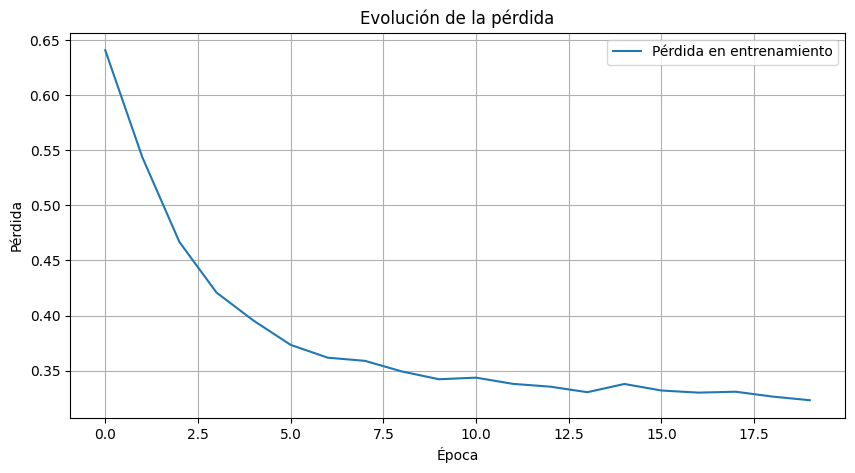

In [ ]:
epoch_train_losses = []

for epoch in range(20):
    my_net.train()
    current_epoch_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = my_net(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_epoch_loss += loss.item()

        if i % 50 == 49:    # Every 50 mini-batches
            # Print average loss up to the current batch for progress indication
            print(f'[{epoch + 1}, {i + 1:5d}] pérdida: {current_epoch_loss / (i+1):.3f}')

    # Calculate average loss for the entire epoch
    avg_epoch_loss = current_epoch_loss / len(train_dataloader)
    epoch_train_losses.append(avg_epoch_loss)
    print(f'Pérdida promedio época {epoch + 1}  : {avg_epoch_loss:.3f}')


plt.figure(figsize=(10, 5))
plt.plot(epoch_train_losses, label='Pérdida en entrenamiento')
plt.title('Evolución de la pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

### Evaluación

Cuando ya tenemos nuestro _modelo_ definitivo (es decir, con los pesos a los que llegamos), podemos evaluarlo con nuestro conjunto de testeo. Es muy importante que la evaluación se haga sobre un conjunto distinto al que entrenamos porque nuestro modelo podría haber memorizado nuestro conjunto de entrenamiento,  pero fallar al evaluar sobre datos desconocidos (este fenómeno se llama _sobreajuste_).

Precision: 0.841705858707428
Recall: 0.8873599767684937
F1: 0.8639301657676697
Accuracy: 0.8602399826049805


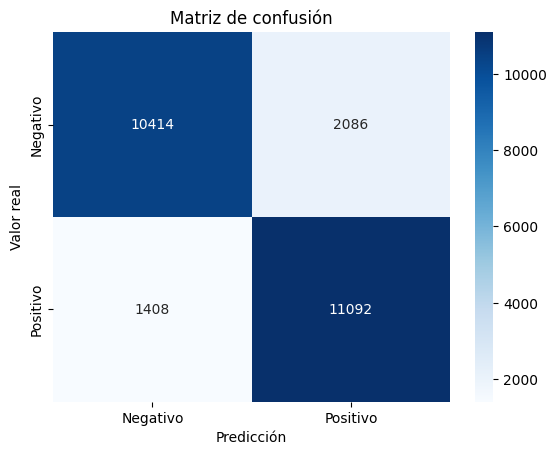

In [ ]:
precision = tm.BinaryPrecision()
recall = tm.BinaryRecall()
f1 = tm.BinaryF1Score()
accuracy = tm.BinaryAccuracy()
confusion_matrix = tm.BinaryConfusionMatrix()

# Evaluamos sobre test
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = my_net(inputs).squeeze(1)
        labels = labels.type(torch.int32)

        precision.update(outputs, labels)
        recall.update(outputs, labels)
        f1.update(outputs, labels)
        accuracy.update(outputs, labels)
        confusion_matrix.update(outputs, labels)

print(f"Precision: {precision.compute()}")
print(f"Recall: {recall.compute()}")
print(f"F1: {f1.compute()}")
print(f"Accuracy: {accuracy.compute()}")

# Confusion matrix
cm = confusion_matrix.compute().cpu().numpy()

df_cm = pd.DataFrame(cm, index = [i for i in ["Negativo", "Positivo"]],
                  columns = [i for i in ["Negativo", "Positivo"]])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

---
# Entrenando un Transformer con PyTorch

En esta sección construiremos y entrenaremos una red neuronal con arquitectura Transformer para una tarea sencilla: traducción de palabras a [jeringoso](https://es.wikipedia.org/wiki/Jerigonza).

La arquitectura Transformer es la que está detrás de todos los Grandes Modelos de Lenguaje, pero no deja de ser una red neuronal (bastante) más compleja que una red feedforward.

El objetivo con el que se entrena un LLM (en realidad,  aquellos basados en arquitecturas Decoder Only), es predecir la siguiente palabra (o, para ser más exactos, el siguiente _token_) dados los anteriores. En nuestro caso, nuestros tokens serán las letras de una palabra, y nuestra salida será la versión en jeringoso de la propia palabra.  Para ello, entrenaremos un LLM utilizando ejemplos "reales" de palabras traducidas al jeringoso por un algoritmo determinista, e intentaremos que nuestro LLM "aprenda" a traducir.


---

## Reglas del jeringoso

Una palabra se traduce a jeringoso aplicando las siguientes reglas:

1. Separar la palabra en sílabas
2. Tomar la última ocurrencia de una vocal en cada sílaba
3. agregar luego de la vocal la letra "p" y repetir la vocal

Por ejemplo, para la palabra "aeropuerto":

1. a - e - ro - puer - to
2. **a** - **e** - r**o** - pu**e**r - t**o**
3. **apa** - **epe** - r**opo** - pu**epe**r - t**opo**

Entonces, nos queda "apaeperopopuepertopo."

## Probando ChatGPT

ChatGPT *sin razonamiento* (GPT-5 Instant) no es bueno traduciendo palabras a jeringoso. Para el ejemplo anterior, pasando las reglas en el prompt, retorna: **aeperopuepertopo**.

**¿Por qué los LLMs podrían tener problemas para resolver esta tarea?**

## Generación de datos

Como esta es una tarea sencilla, podemos construir una función que realice la tarea utilizando una biblioteca que separa en sílabas (silabeador) y aplicando las reglas ya mencionadas. La siguiente función realiza esto:

In [ ]:
import silabeador

NO_ACC = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}

def to_jeringoso(word):
  try:
    sylls = silabeador.syllabify(word)
  except Exception:
    return None
  out = ""
  for syll in sylls:
    new_syll = ""
    for i in range(len(syll)-1, -1, -1):
      vocal = NO_ACC.get(syll[i].lower(), syll[i].lower())
      if vocal in "aeiou":
        new_syll = syll[i] + "p" + vocal + new_syll
        break
      else:
        new_syll = syll[i] + new_syll
    out += syll[0:i] + new_syll
  return out

print(to_jeringoso("aeropuerto"))
print(to_jeringoso("camaleón"))

apaeperopopuepertopo
capamapalepeópon


Ahora, utilizaremos un corpus de palabras disponible en NLTK (una biblioteca muy popular de procesamiento de lenguaje natural) para generar muchos ejemplos de pares <palabra_español, palabra_jeringoso> , y separaremos el conjunto en train y test.

In [ ]:
import nltk
from nltk.corpus import cess_esp

nltk.download('cess_esp')

spanish_words = cess_esp.words()

print("Cantidad de palabras:", len(spanish_words))

spanish_words = list(set(spanish_words))
print("Cantidad de palabras únicas:", len(spanish_words))

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.


Cantidad de palabras: 192686
Cantidad de palabras únicas: 25464


In [ ]:
print(spanish_words[0:10])

['balonmano', 'bursátiles', 'autómatas', 'mueven', 'empresa', 'chándal', 'caribeña', 'comienza', 'Avenida_Paulista', 'decorosa']


In [ ]:
# "Traducir" a jeringoso
words = []
jeringoso_words = []
for word in spanish_words:
  jeringoso_word = to_jeringoso(word)
  if jeringoso_word is not None:
    words.append(word)
    jeringoso_words.append(jeringoso_word)

# Crear DataFrame
data = {'word': words, 'jeringoso': jeringoso_words}
df_jeringoso = pd.DataFrame(data)

# Dividir en train y test
train_df, test_df = train_test_split(df_jeringoso, test_size=0.2, random_state=42)

print("DataFrame original:")
print(df_jeringoso.head())
print("\nTrain DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

DataFrame original:
         word           jeringoso
0   balonmano   bapaloponmapanopo
1  bursátiles  bupursápatipilepes
2   autómatas   auputópomapatapas
3      mueven          muepevepen
4     empresa       epemprepesapa

Train DataFrame shape: (20358, 2)
Test DataFrame shape: (5090, 2)


## Tokenizador

Ahora construiremos el tokenizador. Debido a que nuestro problema es a nivel de caracteres, nos vamos a armar un tokenizador de caracteres.

Vamos a agregar tres tokens especiales:

- **\<pad>:** para realizar padding de las secuencias
- **\<bos>:** para marcar el inicio de la secuencia en jeringoso
- **\<eos>:** para marcar el fin de una secuencia

Nuestro tokenizador tiene que contar con dos métodos principales:

- **encode:** dada una secuencia de caracteres (una palabra), retorna la lista de identificadores de los caracteres
- **decode:** dada una lista de identificadores de caracteres, retorna la secuencia de caracteres (la palabra)

In [ ]:
SPECIAL_TOKENS = ["<pad>", "<bos>", "<eos>"]

class CharVocab:
  def __init__(self, chars):
    chars = sorted(set(chars))
    self.vocab = SPECIAL_TOKENS + chars
    self.v2i = {c:i for i,c in enumerate(self.vocab)}
    self.pad_id = self.v2i["<pad>"]
    self.bos_id = self.v2i["<bos>"]
    self.eos_id = self.v2i["<eos>"]

  def encode(self, input, add_eos=False, add_bos=False):
    ids = []
    if add_bos:
      ids.append(self.bos_id)
    for c in input:
      ids.append(self.v2i[c])
    if add_eos:
      ids.append(self.eos_id)
    return ids

  def decode(self, ids):
    chars = []
    for i in ids:
      if i in (self.pad_id, self.bos_id, self.eos_id):
        continue
      chars.append(self.vocab[i])
    return "".join(chars)

Ahora, inicializamos el tokenizador con los caracteres de nuestros conjuntos de train y test. Es decir que nuestros tokens y nuestro vocabulario serán simplemente caracteres.

In [ ]:
def make_vocab(pairs):
  chars = set()
  for s, t in pairs:
    chars.update(list(s))
    chars.update(list(t))
  vocab = CharVocab(list(chars))
  return vocab

train_pairs = train_df[["word", "jeringoso"]].values.tolist()
val_pairs = test_df[["word", "jeringoso"]].values.tolist()

vocab = make_vocab(train_pairs + val_pairs)

print("Vocab size:", len(vocab.vocab))
print("'Hola' ->", vocab.encode("Hola", add_bos=True, add_eos=True))

Vocab size: 93
'Hola' -> [1, 33, 67, 64, 53, 2]


## Dataset

Una vez tenemos el tokenizador, podemos construir nuestro Dataset, heredando de la clase abstracta Dataset de PyTorch.

Vamos a querer que el método `__getitem__` retorne tres cosas:

- La entrada al encoder del transformer (palabra en español) tokenizada
- La entrada al decoder del transformer (palabra en jeringoso) tokenizada (para _teacher forcing_)
- La salida esperada (palabra en jeringoso) tokenizada

In [ ]:
class JeringosoDataset(Dataset):
  def __init__(self, pairs, vocab):
    self.pairs = pairs
    self.vocab = vocab

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    src, tgt = self.pairs[idx]
    src_ids = self.vocab.encode(src, add_eos=True, add_bos=False) # src: ... <eos>
    tgt_in  = self.vocab.encode(tgt, add_eos=False, add_bos=True) # tgt_in: <bos> ...
    tgt_out = self.vocab.encode(tgt, add_eos=True, add_bos=False) # tgt_out: ... <eos>
    return torch.tensor(src_ids, device=device), torch.tensor(tgt_in, device=device), torch.tensor(tgt_out, device=device)

Ahora inicializamos el dataset para train y test:

In [ ]:
train_ds = JeringosoDataset(train_pairs, vocab)
val_ds = JeringosoDataset(val_pairs, vocab)

print("Train dataset size:", len(train_ds))
print("Val dataset size:", len(val_ds))

Train dataset size: 20358
Val dataset size: 5090


In [ ]:
train_ds[0]

(tensor([38, 53, 71, 71, 57, 66, 54, 73, 70, 59,  2], device='cuda:0'),
 tensor([ 1, 38, 53, 68, 53, 71, 71, 57, 68, 57, 66, 54, 73, 68, 73, 70, 59],
        device='cuda:0'),
 tensor([38, 53, 68, 53, 71, 71, 57, 68, 57, 66, 54, 73, 68, 73, 70, 59,  2],
        device='cuda:0'))

Usaremos la clase `torch.utils.data.Dataloader` para crear los minibatches.

Notar que para poder crear un tensor a partir de un minibatch, todas los ejemplos del minibatch deben tener el mismo largo. Para eso utilizaremos el token especial \<pad> que definimos anteriormente.

Escribiremos la función `collate_fn` que toma como entrada los ejemplos de un minibatch, y retorna los tensores `srcs`, `tgts_in` y `tgts_out` (de rango 2, matrices), donde:

- `srcs` debe tener las palabras en español tokenizadas, completando con el token \<pad> para que todas tengan el mismo largo
- `tgts_in` debe tener las palabras en jeringoso tokenizadas para _teacher forcing_, completando con el token \<pad> para que todas tengan el mismo largo
- `tgts_out` debe tener las palabras en jeringoso tokenizadas para la salida esperada, completando con el token \<pad> para que todas tengan el mismo largo

Utilizaremos el método `nn.utils.rnn.pad_sequence` para realizar el padding de los ejemplos (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html).

In [ ]:
def collate_fn(batch, pad_id):
  srcs, tgts_in, tgts_out = zip(*batch)
  srcs = nn.utils.rnn.pad_sequence(srcs, batch_first=True, padding_value=pad_id)
  tgts_in = nn.utils.rnn.pad_sequence(tgts_in, batch_first=True, padding_value=pad_id)
  tgts_out = nn.utils.rnn.pad_sequence(tgts_out, batch_first=True, padding_value=pad_id)
  return srcs, tgts_in, tgts_out

In [ ]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True,
                      collate_fn=lambda b: collate_fn(b, vocab.pad_id))
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False,
                    collate_fn=lambda b: collate_fn(b, vocab.pad_id))

print("Train batches:", len(train_dl))
print("Val batches:", len(val_dl))

Train batches: 160
Val batches: 40


In [ ]:
next(iter(train_dl))

(tensor([[65, 53, 71,  ...,  0,  0,  0],
         [55, 73, 53,  ...,  0,  0,  0],
         [44, 67, 72,  ...,  0,  0,  0],
         ...,
         [37, 57, 67,  ...,  0,  0,  0],
         [65, 53, 70,  ...,  0,  0,  0],
         [71, 73, 62,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([[ 1, 65, 53,  ...,  0,  0,  0],
         [ 1, 55, 73,  ...,  0,  0,  0],
         [ 1, 44, 67,  ...,  0,  0,  0],
         ...,
         [ 1, 37, 57,  ...,  0,  0,  0],
         [ 1, 65, 53,  ...,  0,  0,  0],
         [ 1, 71, 73,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([[65, 53, 68,  ...,  0,  0,  0],
         [55, 73, 53,  ...,  0,  0,  0],
         [44, 67, 68,  ...,  0,  0,  0],
         ...,
         [37, 57, 68,  ...,  0,  0,  0],
         [65, 53, 68,  ...,  0,  0,  0],
         [71, 73, 68,  ...,  0,  0,  0]], device='cuda:0'))

## Modelo Transformer

**Implementaremos la red Transformer.** Vamos a querer que tenga:

- Una capa de embeddings estáticos entrenables para el encoder (torch.nn.Embedding)
- Otra capa de embeddings estáticos entrenables para el decoder (torch.nn.Embedding)
- Una capa de embeddings posicionales (por simplicidad, también utilizaremos embeddings entrenables para las posiciones, torch.nn.Embedding)
- Una capa transformer (torch.nn.Transformer), que se compone de:
    - **d_model:** la dimensión de entrada (de los embeddings)
    - **nhead:** la cantidad de cabezales de atención
    - **num_encoder_layers:** la cantidad de capas en el encoder
    - **num_decoder_layers:** la cantidad de capas en el decoder
    - **dim_feedforward:** la dimensión interna de la capa feedforward
    - **dropout:** el porcentaje de dropout
    - **batch_first:** determina si la primera dimensión es la de batch (poner en True)
- Una capa lineal (torch.nn.Linear) que va de la salida del transformer a la salida final, que tiene tamaño len(vocab). Esta capa devuelve un valor para cada posible palabra siguiente.

El **forward** deberá realizar los siguientes pasos:

1. Sumar los embeddings de la entrada al encoder con los embeddings posicionales
2. Sumar los embeddings de la entrada al decoder con los embeddings posicionales
3. Realizar la pasada por el encoder (self.transformer.encoder), usaremos una máscara para no calcular la atención en los tokens de padding (parámetro src_key_padding_mask)
4. Realizar la pasada por el decoder (self.transformer.decoder), con:
    - Máscaras para los tokens de padding (tanto para lo que viene del encoder, parámetro memory_key_padding_mask, como lo que viene del decoder, parámetro tgt_key_padding_mask)
    - Máscara causal (parámetro tgt_mask, asumiremos que nos la pasan en la llamada forward)
5. Pasada por la capa lineal final

In [ ]:
class MiniTransformer(nn.Module):
  def __init__(self, vocab, d_model=192, nhead=4, num_layers=2, d_ff=512, dropout=0.1):
    super().__init__()
    self.src_embed = nn.Embedding(len(vocab.vocab), d_model, padding_idx=vocab.pad_id)
    self.tgt_embed = nn.Embedding(len(vocab.vocab), d_model, padding_idx=vocab.pad_id)
    # Capa de embeddings para aprender las posiciones
    self.pos_enc = nn.Embedding(1024, d_model)

    self.transformer = nn.Transformer(
      d_model=d_model,
      nhead=nhead,
      num_encoder_layers=num_layers,
      num_decoder_layers=num_layers,
      dim_feedforward=d_ff,
      dropout=dropout,
      batch_first=True
    )
    self.out_proj = nn.Linear(d_model, len(vocab.vocab))

  def apply_pos_enc(self, emb):
    return emb + self.pos_enc(torch.arange(emb.size(1), device=emb.device))

  def forward(self, src, tgt_in, src_key_padding_mask, tgt_key_padding_mask, tgt_mask):
    src_emb = self.apply_pos_enc(self.src_embed(src))
    tgt_emb = self.apply_pos_enc(self.tgt_embed(tgt_in))

    mem = self.transformer.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)
    out = self.transformer.decoder(
      tgt_emb,
      mem,
      tgt_mask=tgt_mask,
      tgt_key_padding_mask=tgt_key_padding_mask,
      memory_key_padding_mask=src_key_padding_mask
    )
    return self.out_proj(out) # (B, T, V)

In [ ]:
model = MiniTransformer(vocab=vocab).to(device)

print(model)

MiniTransformer(
  (src_embed): Embedding(93, 192, padding_idx=0)
  (tgt_embed): Embedding(93, 192, padding_idx=0)
  (pos_enc): Embedding(1024, 192)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): T

Necesitamos una forma de construir la máscara causal para el decoder. Para ello, usaremos la función torch.triu, que retorna la matriz triangular superior de la matriz pasada por parámetro. El parámetro diagonal=1 excluye la diagonal principal.

In [ ]:
def generate_square_subsequent_mask(size, device):
  # máscara causal para el decoder
  mask = torch.ones(size, size, device=device) * float('-inf')
  return torch.triu(mask, diagonal=1)

## Entrenamiento

Vamos a entrenar el modelo con los datos generados anteriormente. Nuevamente, especificamos la función de pérdida (en este caso, Entropía Cruzada, que calculará la pérdida comparando la predicción de nuestra red con el caracter siguiente en el ejemplo que se esté procesando).

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_id)

def run_epoch(dl, train_mode=True):
  if train_mode:
    model.train()
  else:
    model.eval()

  total = 0.0
  for src, tgt_in, tgt_out in dl:
    src_key_padding_mask = (src == vocab.pad_id)
    tgt_key_padding_mask = (tgt_in == vocab.pad_id)
    tgt_mask = generate_square_subsequent_mask(tgt_in.size(1), device)

    logits = model(src, tgt_in, src_key_padding_mask, tgt_key_padding_mask, tgt_mask)
    loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

    if train_mode:
      opt.zero_grad()
      loss.backward()
      opt.step()

    total += loss.item()
  return total / len(dl)

for epoch in range(1, 11):
  tr_loss = run_epoch(train_dl, train_mode=True)
  val_loss = run_epoch(val_dl, train_mode=False)
  print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | val loss {val_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 01 | train loss 1.3035 | val loss 0.3286
Epoch 02 | train loss 0.2710 | val loss 0.1673
Epoch 03 | train loss 0.1664 | val loss 0.1130
Epoch 04 | train loss 0.1193 | val loss 0.0896
Epoch 05 | train loss 0.0933 | val loss 0.0758
Epoch 06 | train loss 0.0763 | val loss 0.0710
Epoch 07 | train loss 0.0671 | val loss 0.0589
Epoch 08 | train loss 0.0548 | val loss 0.0567
Epoch 09 | train loss 0.0481 | val loss 0.0530
Epoch 10 | train loss 0.0435 | val loss 0.0514


## Evaluación

Finalmente, evaluaremos el rendimiento del modelo sobre el conjunto de test. 

Necesitamos un método de decoding para elegir el siguiente caracter según la distribución de probabilidad de salida. Para ello, implementamos la estrategia de greedy decoding.

Observar que:

- Para la etapa de decodificación, no es necesario recomputar la pasada por el encoder, por lo que lo ejecutamos una vez al principio y reutilizamos su salida durante la decodificación
- La generación es autorregresiva hasta que se genera el token \<eos> o se realizen `max_len` iteraciones
- Podríamos usar KV caché para hacer más eficiente la pasada por el decoder (no lo hacemos por simplicidad)

In [ ]:
from tqdm import tqdm

def greedy_decode(model, src_ids, vocab, max_len, device):
  model.eval()

  # memoria encoder
  src_emb = model.apply_pos_enc(model.src_embed(src_ids))
  mem = model.transformer.encoder(src_emb, src_key_padding_mask=None)

  # generación autorregresiva
  ys = torch.tensor([[vocab.bos_id]], device=device)
  for _ in range(max_len):
    tgt_emb = model.apply_pos_enc(model.tgt_embed(ys))
    tgt_mask = generate_square_subsequent_mask(ys.size(1), device)
    out = model.transformer.decoder(
      tgt_emb,
      mem,
      tgt_mask=tgt_mask,
      memory_key_padding_mask=None
    )
    logits = model.out_proj(out) # (1,T,V)
    next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True) # (1, 1)
    ys = torch.cat([ys, next_token], dim=1) # (1, t+1)
    if next_token.item() == vocab.eos_id:
      break
  return ys.squeeze(0).tolist() # ids

Nos definimos una función para calcular:

- accuracy, que definimos como la proporción de palabras generadas exactamente igual que la salida esperada.
- accuracy a nivel de caracteres, que definimos como la proporción de caracteres en la salida generada que coinciden con los de la salida esperada

In [ ]:
def accuracy_examples(model, ds, vocab, device):
  exact, char_accs = 0, []
  for i in tqdm(range(len(ds))):
    src_ids, _, tgt_out = ds[i]
    src_ids = src_ids.unsqueeze(0).to(device)
    pred_ids = greedy_decode(model, src_ids, vocab, max_len=64, device=device)
    pred = vocab.decode(pred_ids)
    gold = vocab.decode(tgt_out.tolist())
    exact += int(pred == gold)
    # char-level accuracy (simple, longitudes pueden diferir)
    m = max(len(pred), len(gold))
    match = sum(1 for a,b in zip(pred.ljust(m), gold.ljust(m)) if a==b)
    char_accs.append(match / m)
  return exact/len(ds), sum(char_accs)/len(ds)

Finalmente evaluamos y corremos algunos ejemplos.

In [ ]:
# demos
demo = ["aeropuerto", "siempre", "murciélago", "uruguay", "programa", "pelota", "tokenizar", "pilteador"]
print("\nDemos:")
for w in demo:
  src = torch.tensor([vocab.encode(w, add_eos=True)], device=device)
  pred_ids = greedy_decode(model, src, vocab, 64, device)
  print(f"{w} -> {vocab.decode(pred_ids)}   (gold: {to_jeringoso(w)})")


Demos:
aeropuerto -> apaeperopopuepertopo   (gold: apaeperopopuepertopo)
siempre -> siepemprepe   (gold: siepemprepe)
murciélago -> mupurciépelapagopo   (gold: mupurciépelapagopo)
uruguay -> upurupuguapay   (gold: upurupuguapay)
programa -> propograpamapa   (gold: propograpamapa)
pelota -> pepelopotapa   (gold: pepelopotapa)
tokenizar -> topokepenipizapar   (gold: topokepenipizapar)
pilteador -> pipiltepeapadopor   (gold: pipiltepeapadopor)


In [ ]:
# evaluación
em, ca = accuracy_examples(model, val_ds, vocab, device=device)
print(f"Val Exact-Match: {em*100:.1f}% | Char-acc: {ca*100:.1f}%")



100%|██████████| 5090/5090 [04:07<00:00, 20.60it/s]

Val Exact-Match: 93.7% | Char-acc: 98.0%
